In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from scipy.linalg import expm
import pandas as pd

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.0.4
Numpy,1.26.2
SciPy,1.11.4
matplotlib,3.7.4
Number of CPUs,8
BLAS Info,Generic
IPython,8.18.1
Python,"3.9.6 (default, Nov 11 2024, 03:15:38) [Clang 16.0.0 (clang-1600.0.26.6)]"
OS,posix [darwin]
Cython,3.0.11


<h1> Model </h1>

I consider the scattering of only one photon towards a 2-level atom. Also, I assume that several atoms might be in the waveguide (to play the role of a mirror for instance). I work in the subspace :

$$ \ket{1,0}, \ket{0,1} $$

And the Hamiltonian is given by: 

$$ H = \sum_k \omega_k a_k^{\dagger} a_k + \frac{1}{2} \sum_j \Omega_j (1 + \sigma_j^z) + \sum_{k,j}\left\{g(k,j) \sigma^+ a_k + \text{h.c} \right\} $$

with $g(k,j) = i g_0 \sqrt{\omega_k} e^{ikx_j}$

<h1> Conduct time evolution </h1>

In [27]:
def get_data_mirror(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, use_WW_approx = True, print_nb_modes = False):
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    omega_tab = np.abs(k_tab)
    n_modes = len(k_tab)
    if print_nb_modes:
        print("Number of modes: ", n_modes)

    #Creation of the Hamiltonian
    dim_subspace = n_modes + 1
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    print("Preparing the Hamiltonian ...")
    ##diagonal elements
    for i in range(n_modes):
        H_matrix[i, i] = omega_tab[i]
    
        if use_WW_approx:
        ##off diagonal elements
            H_matrix[n_modes, i] = g_0*np.sqrt(omega_A / L)*1j
        else:
            H_matrix[n_modes, i] = g_0*np.sqrt(omega_tab[i] / L)*1j
        H_matrix[i,n_modes] = np.conjugate(H_matrix[n_modes,i])
    
    H_matrix[n_modes, n_modes] = omega_A

    H = qt.Qobj(H_matrix)
    #hermicity check
    if not H.isherm:
        print("Hermicity of the Hamiltonian: ", H.isherm)
        return None
    #also obtain the free hamiltonian
    H_free = qt.Qobj(np.diag(np.diag(H_matrix)))

    print("Initializing the state ...")
    ##Initial state
    k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]
    x_bar = x_0

    init_state = 0
    for i in range(n_modes): ##only the modes with positive momentum are excited at the beginning
        coef = np.exp(-0.5*sigma**2*(k_tab[i] - k_bar)**2 -1j * k_tab[i] * x_bar)
        init_state += coef * qt.basis(dim_subspace, i)
    init_state = init_state.unit()
    
    print("Launching the time evolution ...")
    #time evolution
    n_step = int(T/dt)
    times = np.linspace(0, T, n_step)
    result = qt.sesolve(H, init_state, times, options={"nsteps":10000, "progress_bar": True, "store_states": True})
    state_list = result.states

    #also get the free evolution of the initial state
    result_free = qt.sesolve(H_free, init_state, times, options={"nsteps":10000, "store_states": True})
    state_list_free = result_free.states
    
    #Extracting the populations of the modes and the atom
    N_k_t = np.zeros((n_modes, n_step))
    N_A_t = np.zeros(n_step)
    overlap_free_evol = np.zeros(n_step)


    print("Computing occupation numbers in momentum space...")
    for t in tqdm(range(n_step)):
        current_state = state_list[t]

        for i in range(n_modes):
            momentum_state = qt.basis(dim_subspace, i)
            N_k_t[i, t] = np.abs(momentum_state.dag() * current_state)**2

        atomic_state = qt.basis(dim_subspace, n_modes)
        N_A_t[t] += np.abs(atomic_state.dag() * current_state)**2
        
        overlap_free_evol[t] = np.abs(state_list_free[t].dag() * current_state)**2

    return times, k_tab, N_k_t, N_A_t, overlap_free_evol

<h1> First test </h1>

Check the parameters first

In [42]:
L = 200*pi
T = L/2
dt = 0.1

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.1
omega_A = 3
gamma = 2*g_0**2*omega_A

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma
x_0 = -L/4
omega_0 = 2.99

#numerical implementation of momentum space
omega_max = 5*omega_A

print("Coupling g(k,j): ", g_0*np.sqrt(omega_A / L))
print("sigma_momentum: ", sigma_momentum)
print("Decay rate gamma: ", gamma)


Coupling g(k,j):  0.00690988298942671
sigma_momentum:  0.025464790894703253
Decay rate gamma:  0.06000000000000001


Now, run the function

In [43]:
times, k_tab, N_k_t, N_A_t, overlap_free_evol = get_data_mirror(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, print_nb_modes = True)

Number of modes:  3001
Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.0%. Run time:   5.82s. Est. time left: 00:00:00:52
20.0%. Run time:  11.10s. Est. time left: 00:00:00:44
30.0%. Run time:  16.37s. Est. time left: 00:00:00:38
40.0%. Run time:  21.95s. Est. time left: 00:00:00:32
50.0%. Run time:  27.85s. Est. time left: 00:00:00:27
60.0%. Run time:  33.74s. Est. time left: 00:00:00:22
70.0%. Run time:  38.73s. Est. time left: 00:00:00:16
80.0%. Run time:  43.69s. Est. time left: 00:00:00:10
90.0%. Run time:  48.68s. Est. time left: 00:00:00:05
100.0%. Run time:  53.68s. Est. time left: 00:00:00:00
Total run time:  53.68s
Computing occupation numbers in momentum space...


  0%|          | 0/3141 [00:00<?, ?it/s]

<h1> R and T coefficients </h1>

Try to define reflection and transmission cofficients ? Let me define:

$N_k = a_k^{\dagger} a_k$ and $N_x = a_x^{\dagger} a_x$ where :

$$a_x = \frac{1}{\sqrt{N}} \sum_k e^{ikx} a_k$$

I can define : 

$$P_-(t) = \sum_{k < 0} N_k \,\, , \,\, P_+(t) = \sum_{k > 0} N_k $$

It is also interesting to check that the atomic number remains close to zero :

$$ N_A = \sum_j \left(\frac{1+\sigma_j^z}{2}\right)$$

The transmission coefficient is $T = P_+(\infty)$ and the reflection is $R = P_-(\infty)$

Results from summation per modes
T =  0.20187354810647754
R =  0.7968289534237476
Final occupation of the atom =  0.0012974984697757862
---------------------------------------------------------
Results from overlap
T =  0.044701863848162715
R =  0.9540006376820616
Final occupation of the atom =  0.0012974984697757862


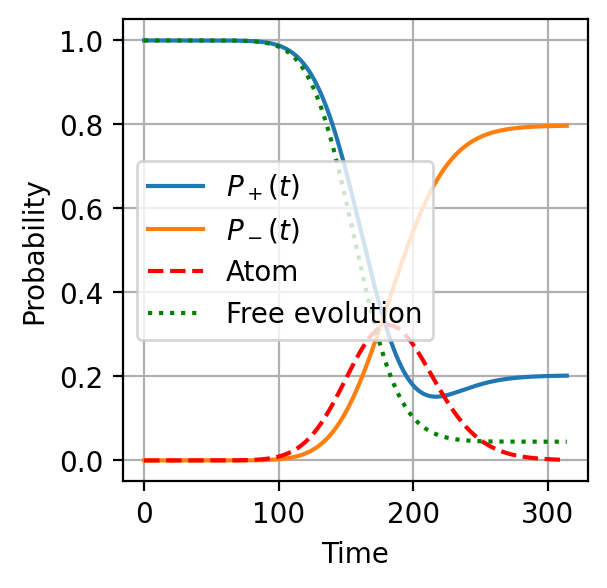

In [44]:
n_modes = N_k_t.shape[0]

nb_pts = len(times)
P_p = np.zeros(nb_pts)
P_m = np.zeros(nb_pts)

for t in range(nb_pts):
    for i in range(n_modes): 
        if k_tab[i] > 0:
            P_p[t] += N_k_t[i,t]
        else:
            P_m[t] += N_k_t[i,t]


print("Results from summation per modes")
print("T = ", P_p[-1])
print("R = ", P_m[-1])
print("Final occupation of the atom = ", N_A_t[-1])
print("---------------------------------------------------------")
print("Results from overlap")
print("T = ", overlap_free_evol[-1])
print("R = ", 1- overlap_free_evol[-1]- N_A_t[-1])
print("Final occupation of the atom = ", N_A_t[-1]) 


fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(times, P_p, label=r'$P_+(t)$')
ax.plot(times, P_m, label=r'$P_-(t)$')
#ax.plot(times, P_p+P_m, label=r'$P_+ + P_-$', linestyle='--', alpha=0.5) 
ax.plot(times, N_A_t, label='Atom', linestyle='--', color='red')   
ax.plot(times, overlap_free_evol, label='Free evolution', linestyle=':', color='green')
ax.set_xlabel('Time')
ax.set_ylabel('Probability')
ax.legend()
ax.grid()

plt.show()

<h2> Occupation number of one specific mode </h2>

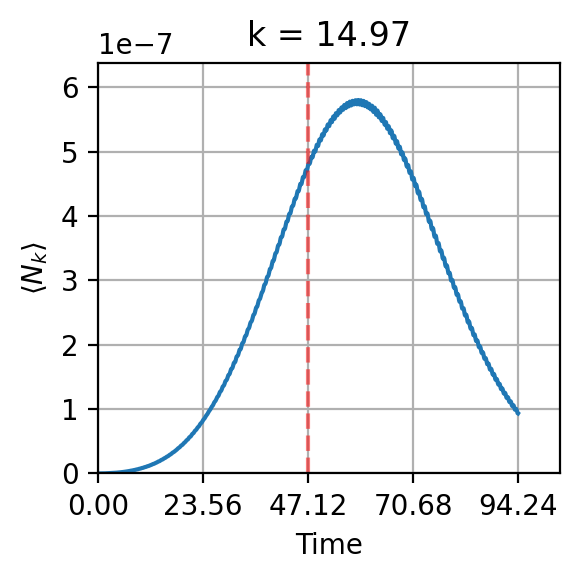

In [80]:
k_target = 6*omega_0
k_index = np.argmin(np.abs(k_tab - k_target))

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

ax.plot(times, N_k_t[k_index,:])
ax.set_xlim(0, 1.1*times[-1])
ax.set_xticks(np.floor(100*np.array([0, T/4, T/2, 3*T/4, T]))/100)
ax.set_xlabel('Time')
ax.vlines(T/2, 0, 1, color='r', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1.1*np.max(N_k_t[k_index,:]))
ax.set_ylabel(r'$\langle N_k \rangle$')
ax.set_title("k = {:.2f}".format(k_tab[k_index]))
ax.grid()

fig.tight_layout()
plt.show()

<h1> UV Cut-off </h1>

Apparently, the UV cutoff has its importance ... let's check it. First; I rearrange my function to get only the final reflection coefficient and the final atomic occupation number

In [52]:
def get_data_mirror_UV_simu(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, use_WW_approx = True, print_nb_modes = False):
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    omega_tab = np.abs(k_tab)
    n_modes = len(k_tab)
    if print_nb_modes:
        print("Number of modes: ", n_modes)

    #Creation of the Hamiltonian
    dim_subspace = n_modes + 1
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    print("Preparing the Hamiltonian ...")
    ##diagonal elements
    for i in range(n_modes):
        H_matrix[i, i] = omega_tab[i]
    
        if use_WW_approx:
        ##off diagonal elements
            H_matrix[n_modes, i] = g_0*np.sqrt(omega_A / L)*1j
        else:
            H_matrix[n_modes, i] = g_0*np.sqrt(omega_tab[i] / L)*1j
        H_matrix[i,n_modes] = np.conjugate(H_matrix[n_modes,i])
    
    H_matrix[n_modes, n_modes] = omega_A

    H = qt.Qobj(H_matrix)
    #hermicity check
    if not H.isherm:
        print("Hermicity of the Hamiltonian: ", H.isherm)
        return None
    #also obtain the free hamiltonian
    H_free = qt.Qobj(np.diag(np.diag(H_matrix)))

    print("Initializing the state ...")
    ##Initial state
    k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]
    x_bar = x_0

    init_state = 0
    for i in range(n_modes): ##only the modes with positive momentum are excited at the beginning
        coef = np.exp(-0.5*sigma**2*(k_tab[i] - k_bar)**2 -1j * k_tab[i] * x_bar)
        init_state += coef * qt.basis(dim_subspace, i)
    init_state = init_state.unit()
    
    print("Launching the time evolution ...")
    #time evolution
    n_step = int(T/dt)
    times = np.linspace(0, T, n_step)
    result = qt.sesolve(H, init_state, times, options={"nsteps":10000, "progress_bar": True, "store_states": True})
    state_list = result.states

    #also get the free evolution of the initial state
    result_free = qt.sesolve(H_free, init_state, times, options={"nsteps":10000, "store_states": True})
    state_list_free = result_free.states
    
    #Extracting the populations of the modes and the atom at final time
    final_state = state_list[-1]
    final_state_free = state_list_free[-1]

    R_coef = 0
    T_coef = 0
    print("Computing the final quantities of interest ...")
    for i in range(n_modes):
        momentum_state = qt.basis(dim_subspace, i)
        N_k_final = np.abs(momentum_state.dag() * final_state)**2
        if k_tab[i] > 0:
            T_coef += N_k_final
        else:
            R_coef += N_k_final

    atomic_state = qt.basis(dim_subspace, n_modes)
    N_A_final = np.abs(atomic_state.dag() * final_state)**2
        
    final_free_overlap = np.abs(final_state_free.dag() * final_state)**2

    return R_coef, T_coef, N_A_final, final_free_overlap

Then, perform simulations for several UV cutoff

In [53]:
L = 250*pi
T = L/2
dt = 0.1

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.1
omega_A = 3
gamma = 2*g_0**2*omega_A

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma
x_0 = -L/4
omega_0 = 2.99 #almost resonant with the atom


nb_freq = 20
omega_max_tab = np.linspace(2*omega_A, 10*omega_A, nb_freq)

reflection_tab = np.zeros(nb_freq)
transmission_tab = np.zeros(nb_freq)
N_A_final_tab = np.zeros(nb_freq)
overlap_free_evol_tab = np.zeros(nb_freq)


for x in tqdm(range(nb_freq)):
    omega_max = omega_max_tab[x]
    R_coef, T_coef, N_A_final, final_free_overlap  = get_data_mirror_UV_simu(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, print_nb_modes = True)

    reflection_tab[x] = R_coef
    transmission_tab[x] = T_coef
    N_A_final_tab[x] = N_A_final
    overlap_free_evol_tab[x] = final_free_overlap
    #Save the results at each iteration
    data = {
        'omega_max': omega_max,
        'reflection': R_coef,
        'transmission': T_coef,
        'N_A_final': N_A_final,
        'overlap_free_evol': final_free_overlap
    }
    df = pd.DataFrame(data, index=[0])
    current_filename = f"./results_UVcutoff/results_{x}.csv"
    df.to_csv(current_filename, index=False)


    

  0%|          | 0/20 [00:00<?, ?it/s]

Number of modes:  1501
Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.0%. Run time:   0.93s. Est. time left: 00:00:00:08
20.0%. Run time:   1.78s. Est. time left: 00:00:00:07
30.0%. Run time:   2.54s. Est. time left: 00:00:00:05
40.0%. Run time:   3.29s. Est. time left: 00:00:00:04
50.0%. Run time:   4.05s. Est. time left: 00:00:00:04
60.0%. Run time:   4.89s. Est. time left: 00:00:00:03
70.0%. Run time:   5.79s. Est. time left: 00:00:00:02
80.0%. Run time:   6.66s. Est. time left: 00:00:00:01
90.0%. Run time:   7.58s. Est. time left: 00:00:00:00
100.0%. Run time:   8.47s. Est. time left: 00:00:00:00
Total run time:   8.47s
Computing the final quantities of interest ...
Number of modes:  1815
Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.0%. Run time:   1.51s. Est. time left: 00:00:00:13
20.0%. Run time:   3.19s. Est. time left: 00:00:00:12
30.0%. Run time:   4.76s. Est. time left: 00:00:00:11


Treat the results

In [54]:
nb_freq_eff = 20

omega_max_tab = np.zeros(nb_freq_eff)

reflection_tab = np.zeros(nb_freq_eff)
transmission_tab = np.zeros(nb_freq_eff)
N_A_final_tab = np.zeros(nb_freq_eff)
overlap_free_evol_tab = np.zeros(nb_freq_eff)

for x in range(nb_freq_eff):
    #recover the associated csv file
    current_filename = f"./results_UVcutoff/results_{x}.csv"
    df = pd.read_csv(current_filename)

    omega_max_tab[x] = df['omega_max'][0]

    reflection_tab[x] = df['reflection'][0]
    transmission_tab[x] = df['transmission'][0]
    N_A_final_tab[x] = df['N_A_final'][0]
    overlap_free_evol_tab[x] = df['overlap_free_evol'][0]


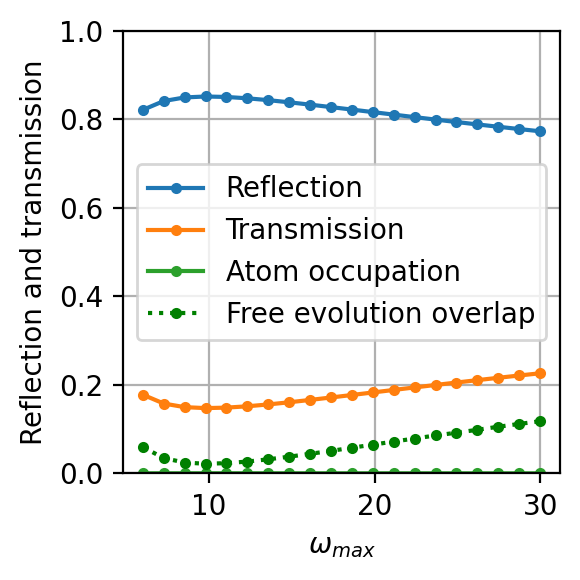

In [55]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(omega_max_tab, reflection_tab, markersize=3, marker='o', label='Reflection')
ax.plot(omega_max_tab, transmission_tab, markersize=3, marker='o', label='Transmission')
ax.plot(omega_max_tab, N_A_final_tab, markersize=3, marker='o', label='Atom occupation')
ax.plot(omega_max_tab, overlap_free_evol_tab, markersize=3, marker='o', label='Free evolution overlap', linestyle=':', color='green')
ax.set_xlabel(r'$\omega_{max}$')
ax.set_ylabel("Reflection and transmission")
ax.grid()
ax.legend()
ax.set_ylim(0, 1)

fig.tight_layout()
plt.show()

<h1> 50/50 Beamsplitter </h1>

In [56]:
def get_data_mirror_reflection(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, use_WW_approx = True, print_nb_modes = False):
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    omega_tab = np.abs(k_tab)
    n_modes = len(k_tab)
    if print_nb_modes:
        print("Number of modes: ", n_modes)

    #Creation of the Hamiltonian
    dim_subspace = n_modes + 1
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    print("Preparing the Hamiltonian ...")
    ##diagonal elements
    for i in range(n_modes):
        H_matrix[i, i] = omega_tab[i]
    
        if use_WW_approx:
        ##off diagonal elements
            H_matrix[n_modes, i] = g_0*np.sqrt(omega_A / L)*1j
        else:
            H_matrix[n_modes, i] = g_0*np.sqrt(omega_tab[i] / L)*1j
        H_matrix[i,n_modes] = np.conjugate(H_matrix[n_modes,i])
    
    H_matrix[n_modes, n_modes] = omega_A

    H = qt.Qobj(H_matrix)
    #hermicity check
    if not H.isherm:
        print("Hermicity of the Hamiltonian: ", H.isherm)
        return None
    #also obtain the free hamiltonian
    H_free = qt.Qobj(np.diag(np.diag(H_matrix)))

    print("Initializing the state ...")
    ##Initial state
    k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]
    x_bar = x_0

    init_state = 0
    for i in range(n_modes): ##only the modes with positive momentum are excited at the beginning
        coef = np.exp(-0.5*sigma**2*(k_tab[i] - k_bar)**2 -1j * k_tab[i] * x_bar)
        init_state += coef * qt.basis(dim_subspace, i)
    init_state = init_state.unit()
    
    print("Launching the time evolution ...")
    #time evolution
    n_step = int(T/dt)
    times = np.linspace(0, T, n_step)
    result = qt.sesolve(H, init_state, times, options={"nsteps":10000, "progress_bar": True, "store_states": True})
    state_list = result.states

    #also get the free evolution of the initial state
    result_free = qt.sesolve(H_free, init_state, times, options={"nsteps":10000, "store_states": True})
    state_list_free = result_free.states
    
    #Extracting the populations of the modes and the atom at final time
    final_state = state_list[-1]
    final_state_free = state_list_free[-1]

    R_coef_sum = 0
    print("Computing the final quantities of interest ...")
    for i in range(n_modes):
        momentum_state = qt.basis(dim_subspace, i)
        N_k_final = np.abs(momentum_state.dag() * final_state)**2
        if k_tab[i] < 0:
            R_coef_sum += N_k_final
    T_coef_sum = 1- R_coef_sum

    print("Computing the final quantities of interest ...")
        
    T_coef = np.abs(final_state_free.dag() * final_state)**2
    R_coef = 1 - T_coef

    return R_coef, T_coef, R_coef_sum, T_coef_sum

Now check for several frequencies of the wave packet

In [57]:
L = 250*pi
T = L/2
dt = 0.1

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.1
omega_A = 3
gamma = 2*g_0**2*omega_A
nb_freq = 20
omega_0_tab = np.linspace(omega_A-0.1, omega_A+0.1, nb_freq)

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma
x_0 = -L/4

omega_max = 10


for x in tqdm(range(nb_freq)):
    omega_0 = omega_0_tab[x]
    R_coef, T_coef, R_coef_sum, T_coef_sum  = get_data_mirror_reflection(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, print_nb_modes = True)

    #Save the results at each iteration
    data = {
        'omega_0': omega_0,
        'reflection': R_coef,
        'transmission': T_coef,
        'R_coef_sum': R_coef_sum,
        'T_coef_sum': T_coef_sum
    }
    df = pd.DataFrame(data, index=[0])
    current_filename = f"./results_transmission/results_{x}.csv"
    df.to_csv(current_filename, index=False)    

  0%|          | 0/20 [00:00<?, ?it/s]

Number of modes:  2501
Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.0%. Run time:   3.92s. Est. time left: 00:00:00:35
20.0%. Run time:   7.25s. Est. time left: 00:00:00:28
30.0%. Run time:  10.94s. Est. time left: 00:00:00:25
40.0%. Run time:  14.41s. Est. time left: 00:00:00:21
50.0%. Run time:  17.69s. Est. time left: 00:00:00:17
60.0%. Run time:  21.30s. Est. time left: 00:00:00:14
70.0%. Run time:  24.63s. Est. time left: 00:00:00:10
80.0%. Run time:  28.53s. Est. time left: 00:00:00:07
90.0%. Run time:  32.46s. Est. time left: 00:00:00:03
100.0%. Run time:  35.81s. Est. time left: 00:00:00:00
Total run time:  35.81s
Computing the final quantities of interest ...
Computing the final quantities of interest ...
Number of modes:  2501
Preparing the Hamiltonian ...
Initializing the state ...
Launching the time evolution ...
10.0%. Run time:   3.40s. Est. time left: 00:00:00:30
20.0%. Run time:   6.67s. Est. time left: 00:00:00:26
30.0%. 

Treat the results

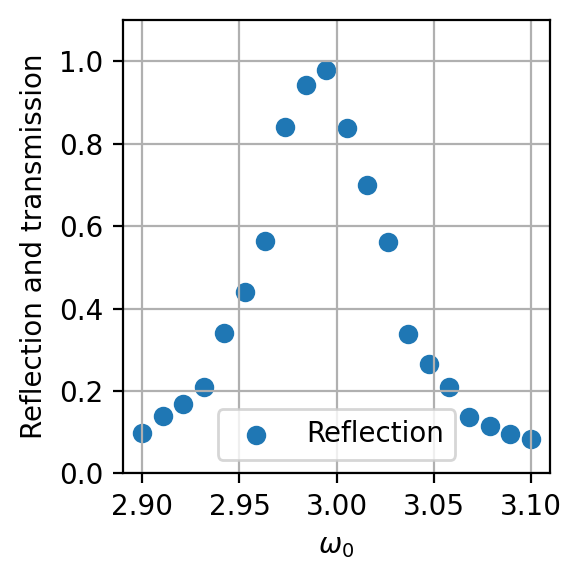

In [62]:
nb_freq_eff = 20

omega_0_tab = np.zeros(nb_freq_eff)
reflection_tab = np.zeros(nb_freq_eff)
transmission_tab = np.zeros(nb_freq_eff)
reflection_sum_tab = np.zeros(nb_freq_eff)
transmission_sum_tab = np.zeros(nb_freq_eff)


for x in range(nb_freq_eff):
    #recover the associated csv file
    current_filename = f"./results_transmission/results_{x}.csv"
    df = pd.read_csv(current_filename)

    omega_0_tab[x] = df['omega_0'][0]
    reflection_tab[x] = df['reflection'][0]
    transmission_tab[x] = df['transmission'][0]
    reflection_sum_tab[x] = df['R_coef_sum'][0]
    transmission_sum_tab[x] = df['T_coef_sum'][0]

theory_curve = 1 / (1 + (omega_0_tab - omega_A)**2 / (gamma/2)**2)

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.scatter(omega_0_tab, reflection_tab, marker='o', label='Reflection')
#ax.scatter(omega_0_tab, reflection_sum_tab, marker='o', label='Reflection sum')
#ax.plot(omega_0_tab, theory_curve, markersize=3, label='Theory', linestyle=':', color='green')
ax.set_xlabel(r'$\omega_0$')
ax.set_ylabel("Reflection and transmission")
ax.grid()
ax.legend()
ax.set_ylim(0, 1.1)

fig.tight_layout()
plt.show()